This notebook looks at previously recorded US Senate and president twitter feeds and performs sentiment analysis

In [1]:
import re
from textblob import TextBlob #a very basic sentiment analysis toolkit. Doesn't get the same level of accuracy as my NN.
import pandas as pd
import pickle
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import Sentiment_LUT
from datetime import timedelta #for accurate plotting of dates%matplotlib inline
from datetime import datetime #to deal with time

First, load up the Neural Network that will be used for this analysis:

In [3]:
nodes=200
sentiment=.2
dimension=50
training_tweets_per_label=100000
with open('NeuralNetwork_hiddenlayer_%s_sentiment_%s_vector_%s_size_%s.pkl'%(nodes,sentiment,dimension,training_tweets_per_label), 'rb') as fid:
    clf2 = pickle.load(fid)
vecIndex=[];
for x in range(0,dimension):
    vecIndex.append('vector_%s'%(x))

# Looking at the U.S. President

Previously collected Pres. Trump's tweets in another notebook and saved them as a csv file.

In [4]:
handle="@realDonaldTrump"
User_tweets=pd.read_csv('User_tweets_%s_sentiment_%s_vector_%s.csv'%(handle,sentiment,dimension))

In [5]:
User_tweets['resultsNN']=clf2.predict(User_tweets.loc[:,vecIndex])

In [6]:
User_tweets[['tweets','timestamp','handle','TextBlob','resultsNN']].sample(3)

,tweets,timestamp,handle,TextBlob,resultsNN
632,before i or anyone saw the classified and or h...,2017-01-08 18:56:20,@realDonaldTrump,negative,0
3139,wow lyin ted cruz really went wacko today made...,2016-05-03 23:02:55,@realDonaldTrump,negative,0
3040,senator lindsey graham called me yesterday ver...,2016-05-13 02:32:52,@realDonaldTrump,positive,1


Averaging over a week:

In [7]:
User_tweets['datetime']=pd.to_datetime(User_tweets['timestamp'])
User_tweets['date diff']=User_tweets.loc[:,'datetime'].dt.week

And compare to NPR:

For Trump: http://www.npr.org/2017/04/30/526106612/what-we-learned-about-the-mood-of-trumps-tweets

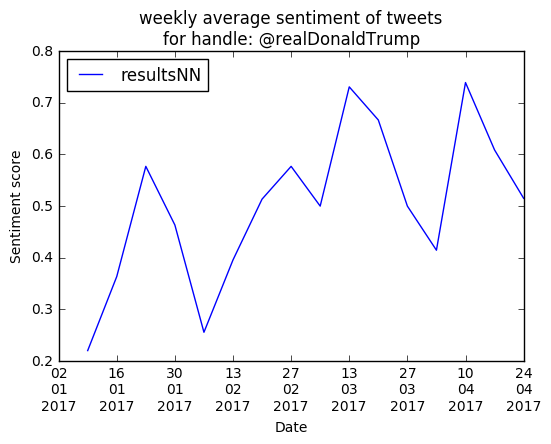

In [8]:
User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,4,23)),['date diff','resultsNN']].groupby('date diff').mean()[:-1].plot()
ax=plt.gca();
plt.xticks(ax.axes.get_xticks(),[(datetime(2017,1,2)+
                              timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()]);
plt.ylabel('Sentiment score')
plt.xlabel('Date')
plt.title('weekly average sentiment of tweets\nfor handle: %s'%(handle))
#plt.savefig('TrumpNPRcheckd50.png',bbox_inches='tight')
plt.show()

A quick aside: negative tweets get more retweets:

In [9]:
User_tweets[['resultsNN','retweet_count']].groupby('resultsNN').mean()

,retweet_count
resultsNN,
0,14297.106602
1,10510.391029


And look so far this year:

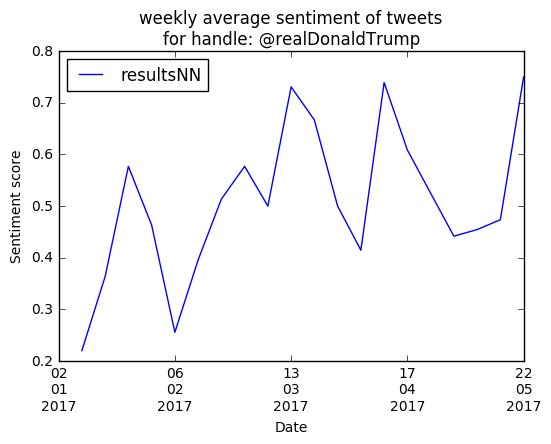

In [10]:
User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1)),['date diff','resultsNN']].groupby('date diff').mean()[:-1].plot()
ax=plt.gca();
plt.xticks(ax.axes.get_xticks(),[(datetime(2017,1,2)+
                              timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()]);
plt.ylabel('Sentiment score')
plt.xlabel('Date')
plt.title('weekly average sentiment of tweets\nfor handle: %s'%(handle))
#plt.savefig('Trumpd50.png',bbox_inches='tight')
plt.show()

Looking at counts and averages over the first 4 months of the year:

Number of tweets:

In [11]:
len(User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),:])

641

In [12]:
User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()

0.47425897035881437

# Looking at the U.S. Senate:

combining all records into single dataframe

In [13]:
senators=pd.read_csv('Senators.csv');

In [14]:
dfs = []
for name in range(0,len(senators)):
    handle=senators.loc[name,'Handle'];
    #dimension=50;
    #sentiment=.2
    try:
        dfs.append(pd.read_csv('User_tweets_%s_sentiment_%s_vector_%s.csv'%(handle,sentiment,dimension)))
    except:
        print("failed to find csv for: %s"%(handle))
        pass
df_Senators = pd.concat(dfs, ignore_index=True)

Sentiment analysis predictions

In [15]:
df_Senators['resultsNN']=clf2.predict(df_Senators.loc[:,vecIndex])

In [16]:
df_Senators[['tweets','handle','TextBlob','resultsNN']].sample(3)

,tweets,handle,TextBlob,resultsNN
173326,had the opportunity to hear how obama s energy...,@SenJohnThune,negative,1
12577,joining the radio show shortly tune in,@SenTomCotton,negative,1
87817,pres trump s eo is 1st step now pass my bill t...,@SenStabenow,negative,0


Adding in a bit of information on party and gender:

In [17]:
df_Senators['Party']=''
df_Senators['Gender']=''
for x in range(0,len(senators)):
    df_Senators.loc[df_Senators.loc[:,'handle']==senators.loc[x,'Handle'],['Party','Gender']]=senators.loc[x,['Party','Gender']].values

In [18]:
df_Senators[['tweets','handle','TextBlob','resultsNN','Party','Gender']].sample(3)

,tweets,handle,TextBlob,resultsNN,Party,Gender
182366,the greatest generation pearlharborremembranceday,@SenTedCruz,positive,1,R,M
67809,do we still have a constitution the constituti...,@RandPaul,negative,0,R,M
46896,i could not support the massive omnibus spendi...,@SenatorRisch,positive,0,R,M


collecting week level averages over party and gender

In [19]:
df_Senators['datetime']=pd.to_datetime(df_Senators['timestamp'])
df_Senators['date diff']=df_Senators.loc[:,'datetime'].dt.week
df_Senators_avg=pd.DataFrame()

df_Senators_avg['Senate']=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),
                   ['date diff','resultsNN','Party','Gender']].groupby('date diff').mean()

df_Senators_avg['R']=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1))&(
        df_Senators.loc[:,'Party'] =='R'),
                   ['date diff','resultsNN','Party','Gender']].groupby('date diff').mean()

df_Senators_avg['D']=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1))&(df_Senators.loc[:,'Party'] =='D'),
                   ['date diff','resultsNN','Party','Gender']].groupby('date diff').mean()

df_Senators_avg['M']=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1))&(df_Senators.loc[:,'Gender'] =='M'),
                   ['date diff','resultsNN','Party','Gender']].groupby('date diff').mean()

df_Senators_avg['F']=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1))&(df_Senators.loc[:,'Gender'] =='F'),
                   ['date diff','resultsNN','Party','Gender']].groupby('date diff').mean()

df_Senators_avg['Week']=list(range(0,len(df_Senators_avg)))

In [20]:
df_Senators_avg.head(3)

,Senate,R,D,M,F,Week
0,NaN,NaN,NaN,NaN,NaN,0
1,0.542312,0.618119,0.490585,0.537175,0.567901,1
2,0.560622,0.655083,0.515815,0.558150,0.570447,2


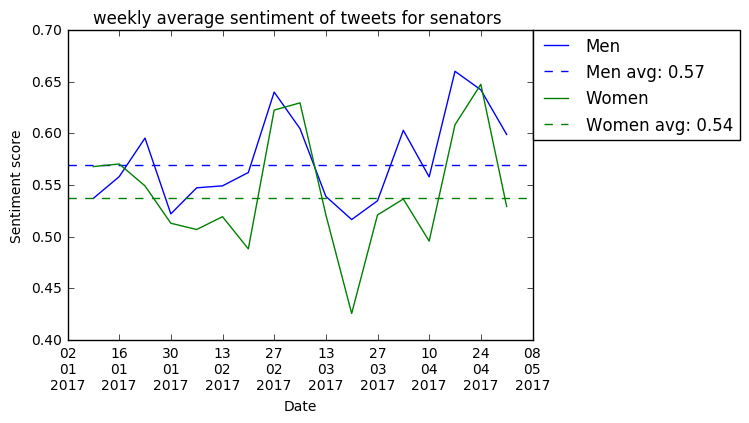

In [21]:
Mavg=df_Senators.loc[(df_Senators.loc[:,'Gender']=='M')&(
        df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()
Favg=df_Senators.loc[(df_Senators.loc[:,'Gender']=='F')&(
        df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()
ax=plt.gca() 
plt.plot(df_Senators_avg['Week'],df_Senators_avg['M'],color='Blue',label='Men')
plt.axhline(Mavg,color='Blue',linestyle='--',label='Men avg: %s'%np.round(Mavg,2))
plt.plot(df_Senators_avg['Week'],df_Senators_avg['F'],color='Green',label='Women')
plt.axhline(Favg,color='Green',linestyle='--',label='Women avg: %s'%np.round(Favg,2))

plt.xticks(ax.get_xticks(),[(datetime(2017,1,2)+
                             timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()])
plt.ylabel('Sentiment score')
plt.xlabel('Date')
#plt.ylim([0.35,.75])
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.)
plt.title('weekly average sentiment of tweets for senators ')
#plt.savefig('SenatorsGender.png',bbox_inches='tight')
plt.show()

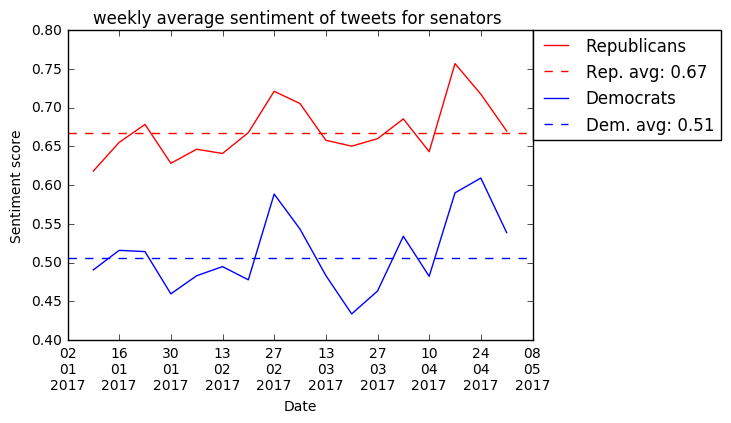

In [22]:
Ravg=df_Senators.loc[(df_Senators.loc[:,'Party']=='R')&(
        df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()
Davg=df_Senators.loc[(df_Senators.loc[:,'Party']=='D')&(
        df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()
ax=plt.gca() 
plt.plot(df_Senators_avg['Week'],df_Senators_avg['R'],color='Red',label='Republicans')
plt.axhline(Ravg,color='Red',linestyle='--',label='Rep. avg: %s'%np.round(Ravg,2))
plt.plot(df_Senators_avg['Week'],df_Senators_avg['D'],color='Blue',label='Democrats')
plt.axhline(Davg,color='Blue',linestyle='--',label='Dem. avg: %s'%np.round(Davg,2))

plt.xticks(ax.get_xticks(),[(datetime(2017,1,2)+
                             timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()])
plt.ylabel('Sentiment score')
plt.xlabel('Date')
#plt.ylim([0.35,.85])
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
plt.title('weekly average sentiment of tweets for senators ')

#plt.savefig('SenatorsParty.png',bbox_inches='tight')
plt.show()

Also looking at number of tweets and average sentiment over the first 4 months of 2017:

In [23]:
senators['2017JanAprSent']=0

a=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),
                   ['handle','resultsNN','Party','Gender']].groupby('handle').mean()

for hand in a.index:
    senators.loc[senators.loc[:,'Handle']==hand,'2017JanAprSent']=a.loc[hand,'resultsNN']
    
senators['2017JanAprCount']=0
a=df_Senators.loc[(df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),
                   ['handle','resultsNN','Party','Gender']].groupby('handle').count()
for hand in a.index:
    senators.loc[senators.loc[:,'Handle']==hand,'2017JanAprCount']=a.loc[hand,'resultsNN']

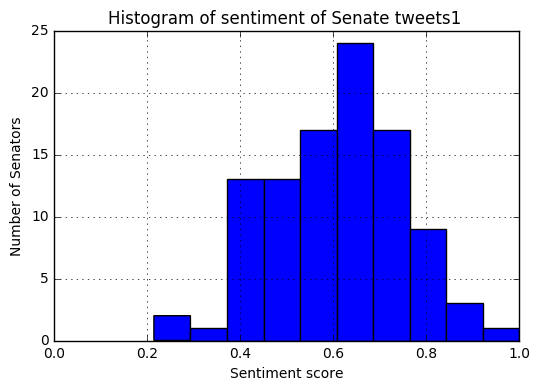

In [24]:
senators['2017JanAprSent'].hist(bins=10)
plt.xlim([0,1])
plt.ylabel('Number of Senators')
plt.xlabel('Sentiment score')
plt.title('Histogram of sentiment of Senate tweets1 ')
plt.show()

Or breaking down by party:

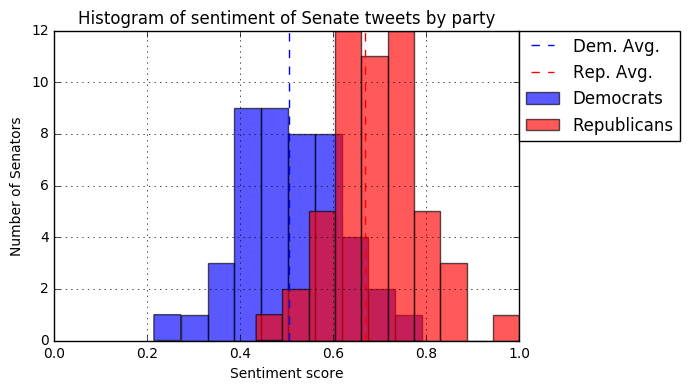

In [25]:
opacity = 0.65
senators.loc[senators.loc[:,'Party']=='D','2017JanAprSent'].hist(bins=10,color='Blue',alpha=opacity,label='Democrats')
senators.loc[senators.loc[:,'Party']=='R','2017JanAprSent'].hist(bins=10,color='Red',alpha=opacity,label='Republicans')
plt.axvline(Davg,linestyle='--',color='Blue',label='Dem. Avg.')
plt.axvline(Ravg,linestyle='--',color='Red',label='Rep. Avg.')
#senators['2017JanAprSent'].hist(bins=10)
plt.xlim([0,1])
plt.ylabel('Number of Senators')
plt.xlabel('Sentiment score')
plt.title('Histogram of sentiment of Senate tweets by party')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
plt.show()

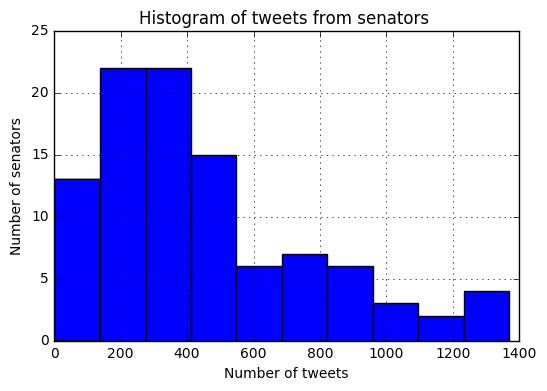

In [26]:
senators['2017JanAprCount'].hist(bins=10)
plt.ylabel('Number of senators')
plt.xlabel('Number of tweets')
plt.title('Histogram of tweets from senators ')
plt.show()

In [27]:
DavgCount=senators.loc[senators.loc[:,'Party']=='D','2017JanAprCount'].mean()
RavgCount=senators.loc[senators.loc[:,'Party']=='R','2017JanAprCount'].mean()

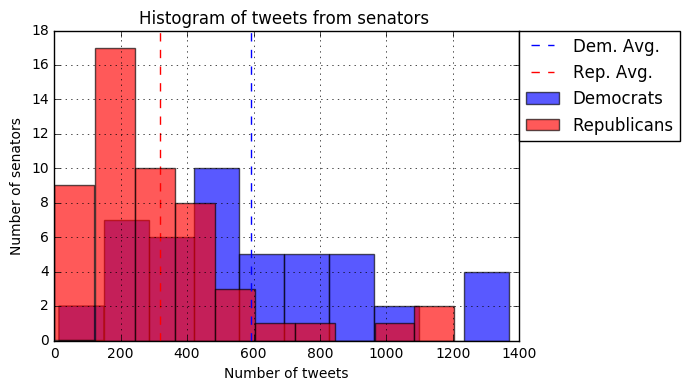

In [28]:
opacity = 0.65
senators.loc[senators.loc[:,'Party']=='D','2017JanAprCount'].hist(bins=10,color='Blue',alpha=opacity,label='Democrats')
senators.loc[senators.loc[:,'Party']=='R','2017JanAprCount'].hist(bins=10,color='Red',alpha=opacity,label='Republicans')
plt.axvline(DavgCount,linestyle='--',color='Blue',label='Dem. Avg.')
plt.axvline(RavgCount,linestyle='--',color='Red',label='Rep. Avg.')
plt.ylabel('Number of senators')
plt.xlabel('Number of tweets')
plt.title('Histogram of tweets from senators ')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
plt.show()

The most extremes of those distributions:

In [29]:
senators.sort_values('2017JanAprSent').head(5)

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
16,Florida,Bill Nelson,@SenBillNelson,D,M,0.214286,14
41,Massachusetts,Elizabeth Warren,@SenWarren,D,F,0.289593,442
89,Vermont,Bernie Sanders,@SenSanders,I,M,0.334118,850
12,Connecticut,Christopher Murphy,@ChrisMurphyCT,D,M,0.375248,1010
20,Hawaii,Brian Schatz,@brianschatz,D,M,0.380090,663


In [30]:
senators.sort_values('2017JanAprSent').tail(5)

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
22,Idaho,Mike Crapo,@MikeCrapo,R,M,0.823529,153
29,Iowa,Joni Ernst,@joniernst,R,F,0.848485,33
23,Idaho,Jim Risch,@SenatorRisch,R,M,0.864583,96
46,Mississippi,Thad Cochran,@SenThadCochran,R,M,0.870370,108
35,Louisiana,John Neely Kennedy,@JohnKennedyLA,R,M,1.000000,1


In [31]:
senators.sort_values('2017JanAprCount').head(5)

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
35,Louisiana,John Neely Kennedy,@JohnKennedyLA,R,M,1.000000,1
16,Florida,Bill Nelson,@SenBillNelson,D,M,0.214286,14
54,Nevada,Catherine Cortez Masto,@CatherineForNV,D,F,0.705882,17
29,Iowa,Joni Ernst,@joniernst,R,F,0.848485,33
53,Nebraska,Ben Sasse,@SenSasse,R,M,0.520548,73


In [32]:
senators.sort_values('2017JanAprCount').tail(5)

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
69,Ohio,Rob Portman,@senrobportman,R,M,0.547718,1205
74,Pennsylvania,Bob Casey Jr.,@SenBobCasey,D,M,0.417417,1332
58,New Jersey,Cory Booker,@CoryBooker,D,M,0.604720,1356
62,New York,Chuck Schumer,@SenSchumer,D,M,0.429619,1364
40,Massachusetts,Ed Markey,@senmarkey,D,M,0.512409,1370


# Combining the Senate and the President:

Before getting to the plots, I could ask: which senator does the president most closely match with?

In [37]:
User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()

0.47425897035881437

In [38]:
len(User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),:])

641

In [40]:
senators.loc[(senators.loc[:,'2017JanAprCount']>600)&(
        senators.loc[:,'2017JanAprCount']<800),:]

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
6,Arkansas,Tom Cotton,@SenTomCotton,R,M,0.769640,751
8,California,Dianne Feinstein,@SenFeinstein,D,F,0.432011,706
15,Delaware,Chris Coons,@ChrisCoons,D,M,0.573482,626
20,Hawaii,Brian Schatz,@brianschatz,D,M,0.380090,663
57,New Hampshire,Maggie Hassan,@SenatorHassan,D,F,0.593656,662
66,North Dakota,Heidi Heitkamp,@SenatorHeitkamp,D,F,0.607947,755
77,Rhode Island,Sheldon Whitehouse,@SenWhitehouse,D,M,0.569554,762
85,Texas,Ted Cruz,@SenTedCruz,R,M,0.694019,719
93,Washington,Maria Cantwell,@SenatorCantwell,D,F,0.472299,722


In [43]:
senators.loc[(senators.loc[:,'2017JanAprSent']>.45)&(
        senators.loc[:,'2017JanAprSent']<.5),:]

,﻿State,Senator,Handle,Party,Gender,2017JanAprSent,2017JanAprCount
9,California,Kamala Harris,@SenKamalaHarris,D,F,0.462754,443
10,Colorado,Michael Bennet,@SenBennetCO,D,M,0.498155,271
25,Illinois,Dick Durbin,@SenatorDurbin,D,M,0.490975,831
48,Missouri,Claire McCaskill,@clairecmc,D,F,0.455026,189
56,New Hampshire,Jeanne Shaheen,@SenatorShaheen,D,F,0.494048,336
60,New Mexico,Martin Heinrich,@MartinHeinrich,D,M,0.493168,805
63,New York,Kirsten Gillibrand,@SenGillibrand,D,F,0.477798,563
73,Oregon,Jeff Merkley,@SenJeffMerkley,D,M,0.496753,924
93,Washington,Maria Cantwell,@SenatorCantwell,D,F,0.472299,722


President looks most like: Chris Coons for Delaware by count
Maria Cantwell for sentiment
combinination of both: <b>Maria Cantwell</b> from Washington by count and sentiment metrics.

## Combined plots

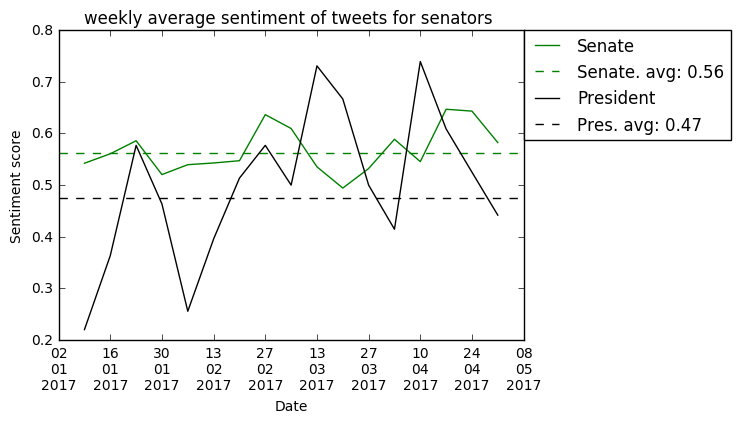

In [39]:
Senateavg=df_Senators.loc[(
        df_Senators.loc[:,'datetime'] > datetime(2017,1,1))&(
        df_Senators.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean()
ax=plt.gca() 
plt.plot(df_Senators_avg['Week'],df_Senators_avg['Senate'],color='Green',label='Senate')
plt.axhline(Senateavg,color='Green',linestyle='--',label='Senate. avg: %s'%np.round(Senateavg,2))

PresTemp=User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&(
    User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),
                ['date diff','resultsNN']].groupby('date diff').mean()[:-1]
plt.plot(PresTemp.index,PresTemp['resultsNN'],color='black',label='President')
PresAverage=User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean();
plt.axhline(PresAverage,color='Black',linestyle='--',label='Pres. avg: %s'%np.round(PresAverage,2))

plt.xticks(ax.get_xticks(),[(datetime(2017,1,2)+
                             timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()])
plt.ylabel('Sentiment score')
plt.xlabel('Date')
#plt.ylim([0.35,.85])
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
plt.title('weekly average sentiment of tweets for senators ')

#plt.savefig('Senators_President.png',bbox_inches='tight')
plt.show()

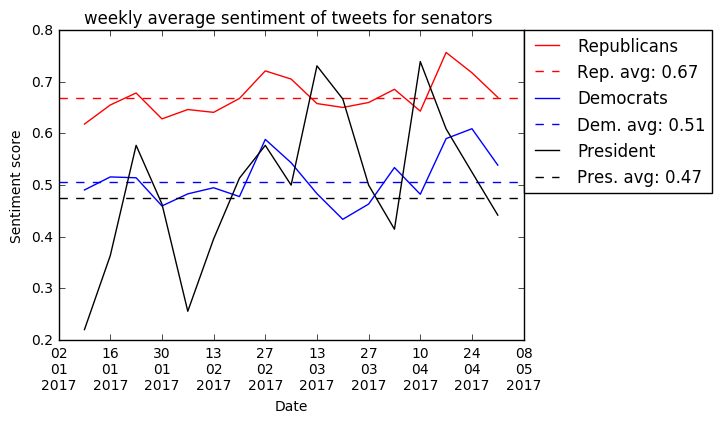

In [40]:
ax=plt.gca() 
plt.plot(df_Senators_avg['Week'],df_Senators_avg['R'],color='Red',label='Republicans')
plt.axhline(Ravg,color='Red',linestyle='--',label='Rep. avg: %s'%np.round(Ravg,2))
plt.plot(df_Senators_avg['Week'],df_Senators_avg['D'],color='Blue',label='Democrats')
plt.axhline(Davg,color='Blue',linestyle='--',label='Dem. avg: %s'%np.round(Davg,2))
PresTemp=User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&(
    User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),
                ['date diff','resultsNN']].groupby('date diff').mean()[:-1]
plt.plot(PresTemp.index,PresTemp['resultsNN'],color='black',label='President')
PresAverage=User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),'resultsNN'].mean();
plt.axhline(PresAverage,color='Black',linestyle='--',label='Pres. avg: %s'%np.round(PresAverage,2))
plt.xticks(ax.get_xticks(),[(datetime(2017,1,2)+
                             timedelta(weeks=int(x))).strftime('%d\n%m\n%Y') for x in ax.get_xticks()])
plt.ylabel('Sentiment score')
plt.xlabel('Date')
#plt.ylim([0.35,.85])
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
plt.title('weekly average sentiment of tweets for senators ')

#plt.savefig('SenatorsParty_President.png',bbox_inches='tight')
plt.show()

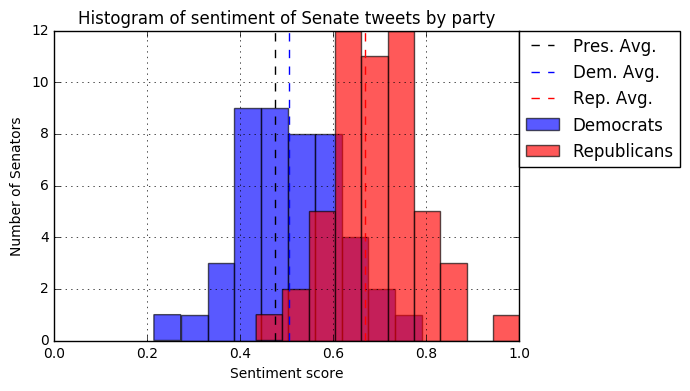

In [41]:
plt.axvline(PresAverage,linestyle='--',color='Black',label='Pres. Avg.')
opacity = 0.65
senators.loc[senators.loc[:,'Party']=='D','2017JanAprSent'].hist(bins=10,color='Blue',alpha=opacity,label='Democrats')
senators.loc[senators.loc[:,'Party']=='R','2017JanAprSent'].hist(bins=10,color='Red',alpha=opacity,label='Republicans')
plt.axvline(Davg,linestyle='--',color='Blue',label='Dem. Avg.')
plt.axvline(Ravg,linestyle='--',color='Red',label='Rep. Avg.')
#senators['2017JanAprSent'].hist(bins=10)
plt.xlim([0,1])
plt.ylabel('Number of Senators')
plt.xlabel('Sentiment score')
plt.title('Histogram of sentiment of Senate tweets by party')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
#plt.savefig('SenatorsHistSentiment_President.png',bbox_inches='tight')
plt.show()

In [42]:
PresNum=len(User_tweets.loc[(User_tweets.loc[:,'datetime'] > datetime(2017,1,1))&
             (User_tweets.loc[:,'datetime'] < datetime(2017,5,1)),:])

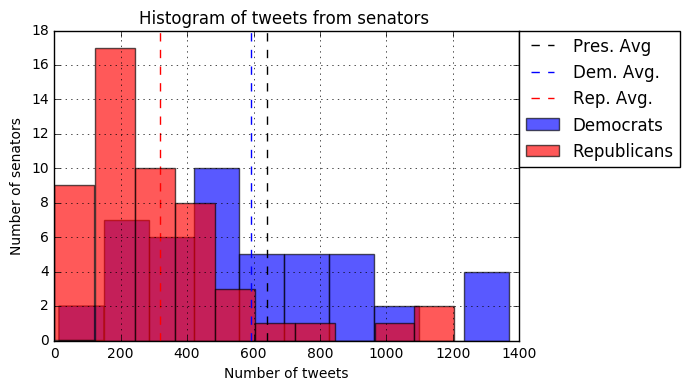

In [43]:
plt.axvline(PresNum,linestyle='--',color='Black',label='Pres. Avg')
opacity = 0.65
senators.loc[senators.loc[:,'Party']=='D','2017JanAprCount'].hist(bins=10,color='Blue',alpha=opacity,label='Democrats')
senators.loc[senators.loc[:,'Party']=='R','2017JanAprCount'].hist(bins=10,color='Red',alpha=opacity,label='Republicans')
plt.axvline(DavgCount,linestyle='--',color='Blue',label='Dem. Avg.')
plt.axvline(RavgCount,linestyle='--',color='Red',label='Rep. Avg.')
plt.ylabel('Number of senators')
plt.xlabel('Number of tweets')
plt.title('Histogram of tweets from senators ')
plt.legend(bbox_to_anchor=(1, 1),loc=2,borderaxespad=0.,ncol=1)
#plt.savefig('SenatorsHistCount_President.png',bbox_inches='tight')
plt.show()